**Computer Vision | Assignment 3 | Object Detection (Fruits)**

**1. Mounting Google Drive**

In [1]:
## mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Conversion of labels from xml to txt**

I will use yolov5 for detection. The given dataset has labels in xml format but yolo uses txt format. This is the reason we first need to convert labels. 

In [2]:
# xml to txt conversion

# COMMAND : py xml_to_txt.py -i car\xmls -o car\txts
# Here you need to change the dictionary as per your classes
import os
import glob
import argparse
from xml.dom import minidom


def convert_coordinates(size, box):
    dw = 1.0/size[0]
    dh = 1.0/size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def xml_to_txt( lut ,input ,output):

    # Start writing  
    for xml in glob.glob( os.path.join(input , "*.xml") ): 
        xmldoc = minidom.parse(xml)  
        # define output filename    
        fname_out = xml.split("/")[-1] 
        fname_out = (os.path.join(output, fname_out.split(".")[0] + '.txt'))

        with open(fname_out, "w") as f:
            # Get image properties
            itemlist = xmldoc.getElementsByTagName('object')
            size = xmldoc.getElementsByTagName('size')[0]
            width = int((size.getElementsByTagName('width')[0]).firstChild.data)
            height = int((size.getElementsByTagName('height')[0]).firstChild.data)

            for item in itemlist:
                # get class label
                classid =  (item.getElementsByTagName('name')[0]).firstChild.data
                if classid in lut:
                    label_str = str(lut[classid])
                else:
                    # label_str = "-1"
                    print ("warning: label '%s' not in look-up table" % classid)
                    continue
                    
                # get bbox coordinates
                xmin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmin')[0]).firstChild.data
                ymin = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymin')[0]).firstChild.data
                xmax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('xmax')[0]).firstChild.data
                ymax = ((item.getElementsByTagName('bndbox')[0]).getElementsByTagName('ymax')[0]).firstChild.data
                b = (float(xmin), float(xmax), float(ymin), float(ymax))
                bb = convert_coordinates((width,height), b)
                # Write out the file
                f.write(label_str + " " + " ".join([("%.6f" % a) for a in bb]) + '\n')

        print ("wrote %s" % fname_out)    


In [3]:
# defining classes in yolo format - starts from 0
# conversion of train labels
lut={}
lut["apple"] = 0
lut["banana"] = 1
lut["orange"] = 2
# Write out to txts
xml_to_txt( lut ,input = '/content/drive/MyDrive/Dataset/Fruits_Data_Set/images/train', output = '/content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train') 

wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_39.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_48.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_24.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_56.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_47.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_66.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_39.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_62.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_47.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_4.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_50.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_13.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Dat

In [4]:
# defining classes in yolo format - starts from 0
# conversion of val labels
lut={}
lut["apple"] = 0
lut["banana"] = 1
lut["orange"] = 2
# Write out to txts
xml_to_txt( lut ,input = '/content/drive/MyDrive/Dataset/Fruits_Data_Set/images/val', output = '/content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val') 

wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_77.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_82.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/banana_80.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_94.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/banana_78.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/banana_83.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/banana_79.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_81.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_90.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_89.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_85.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/apple_87.txt
wrote /content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/val/banana_8

In [5]:
# utility functions to visualzie newly created annotations

from PIL import Image, ImageDraw
import cv2

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        draw.rectangle(bbox, outline="red", width=2)
    #img.save("example.jpg")
    #img.show()
    display(img)


**3. Visualization of sample images with new annotations**

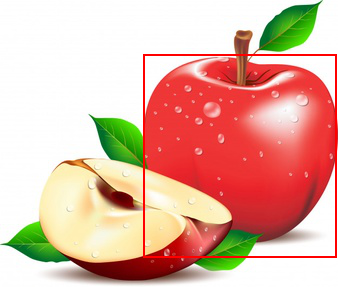

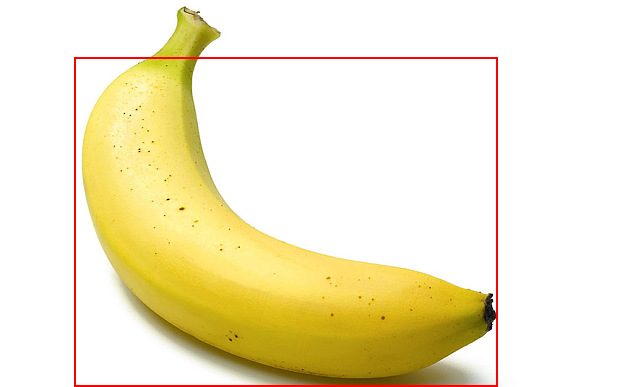

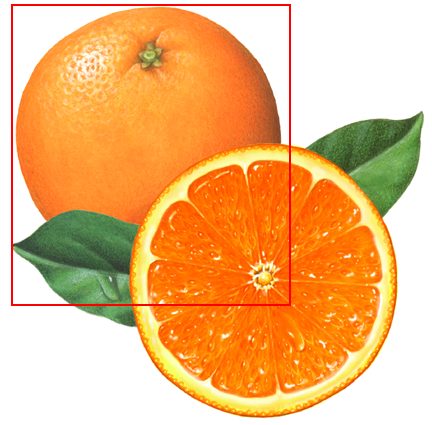

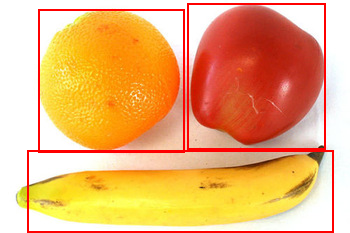

In [6]:

image_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/images/train/apple_41.jpg"
label_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/apple_41.txt"
bboxes = []

img = Image.open(image_filename)
img = img.convert('RGB')

with open(label_filename, 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

draw_image(img, bboxes)

image_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/images/train/banana_36.jpg"
label_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/banana_36.txt"
bboxes = []

img = Image.open(image_filename)
img = img.convert('RGB')

with open(label_filename, 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

draw_image(img, bboxes)

image_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/images/train/orange_18.jpg"
label_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/orange_18.txt"
bboxes = []

img = Image.open(image_filename)
img = img.convert('RGB')

with open(label_filename, 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

draw_image(img, bboxes)

image_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/images/train/mixed_6.jpg"
label_filename = "/content/drive/MyDrive/Dataset/Fruits_Data_Set/labels/train/mixed_6.txt"
bboxes = []

img = Image.open(image_filename)
img = img.convert('RGB')

with open(label_filename, 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

draw_image(img, bboxes)

In [7]:
os.chdir('/content')

**4. Cloning yolov5 repository**

In [8]:
#clone YOLOv5
!git clone https://github.com/ultralytics/yolov5

# Change the current working directory.
%cd yolov5 
!pip install -qr requirements.txt # install dependencies from requirements to use Yolov5 with quiet option

Cloning into 'yolov5'...
remote: Enumerating objects: 14867, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14867 (delta 2), reused 2 (delta 0), pack-reused 14858
Receiving objects: 100% (14867/14867), 13.93 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (10224/10224), done.
/content/yolov5
     |████████████████████████████████| 182 kB 4.6 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 1.6 MB 56.2 MB/s 


In [9]:
import torch
import os
from IPython.display import Image  # to display images

**5. Training on custom dataset through transfer learning**

**5.1 Setting up config file**

*data/fruit_detection.yaml* is the dataset config file that is created below. It is defined by:

- the dataset root directory path
-  nc: the number of classes
-  names: a list of class names

In [10]:
# I will write the contents of the cell to a file

%%writefile /content/yolov5/data/fruit_detection.yaml 

path: /content/drive/MyDrive/Dataset/Fruits_Data_Set # dataset root dir
train: images/train/ # train images (relative to 'path')
val: images/val/ # val images (relative to 'path')
test:  # test images (optional)

# Classes
nc: 3  # number of classes

# class names
names: ['apple', 'banana', 'orange']

     

Writing /content/yolov5/data/fruit_detection.yaml


**5.2 Setting up training paramters**

I am training a YOLOv5 model on fruits data by specifying dataset, batch-size, image size and pretrained --weights yolov5s.pt

Parameters:

- data: Path to the data configuration file

- weights: specify a path to weights to start transfer learning from. yolov5s.pt

- img: Input image size

- batch: Size of a batch

- epochs: No of epochs

In [25]:
# Training YOLOv5s on fruits dataset for 20 epochs
!python train.py --img 320 --batch 16 --epochs 20 --data fruit_detection.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=fruit_detection.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-48-g5f8054c Python-3.8.16 torch-1.13.0+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, tran

In [ ]:
# Start tensorboard
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs/train/

**6. Model performance and Evaluation**

**Training Losses and mAP scores**

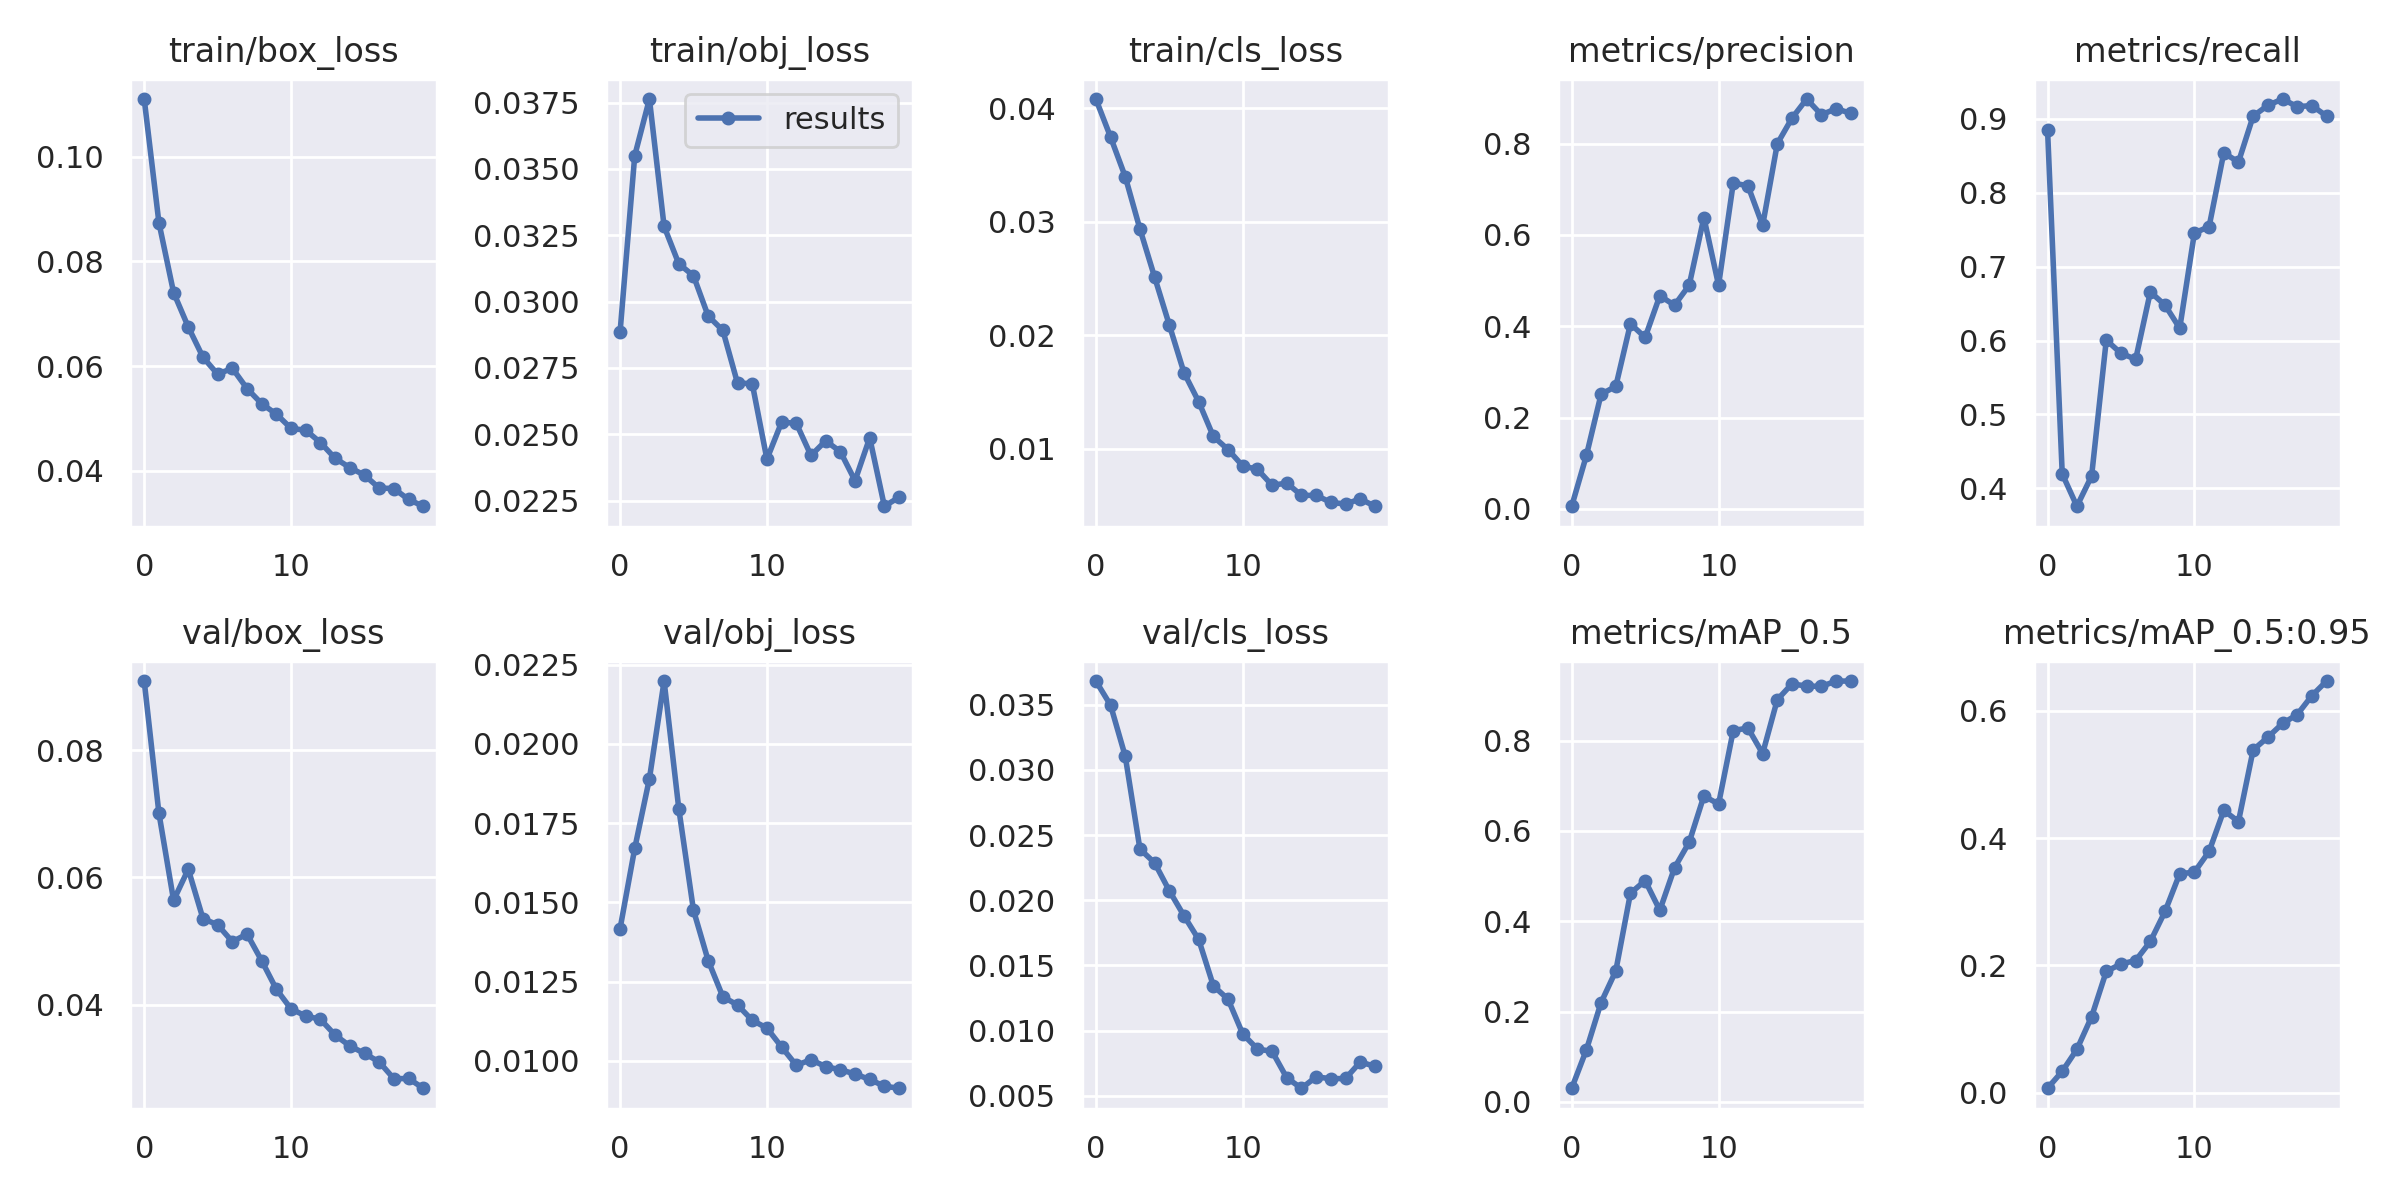

In [32]:
Image(filename='/content/yolov5/runs/train/exp2/results.png', width=800)

**Sample images from val set with ground truth**

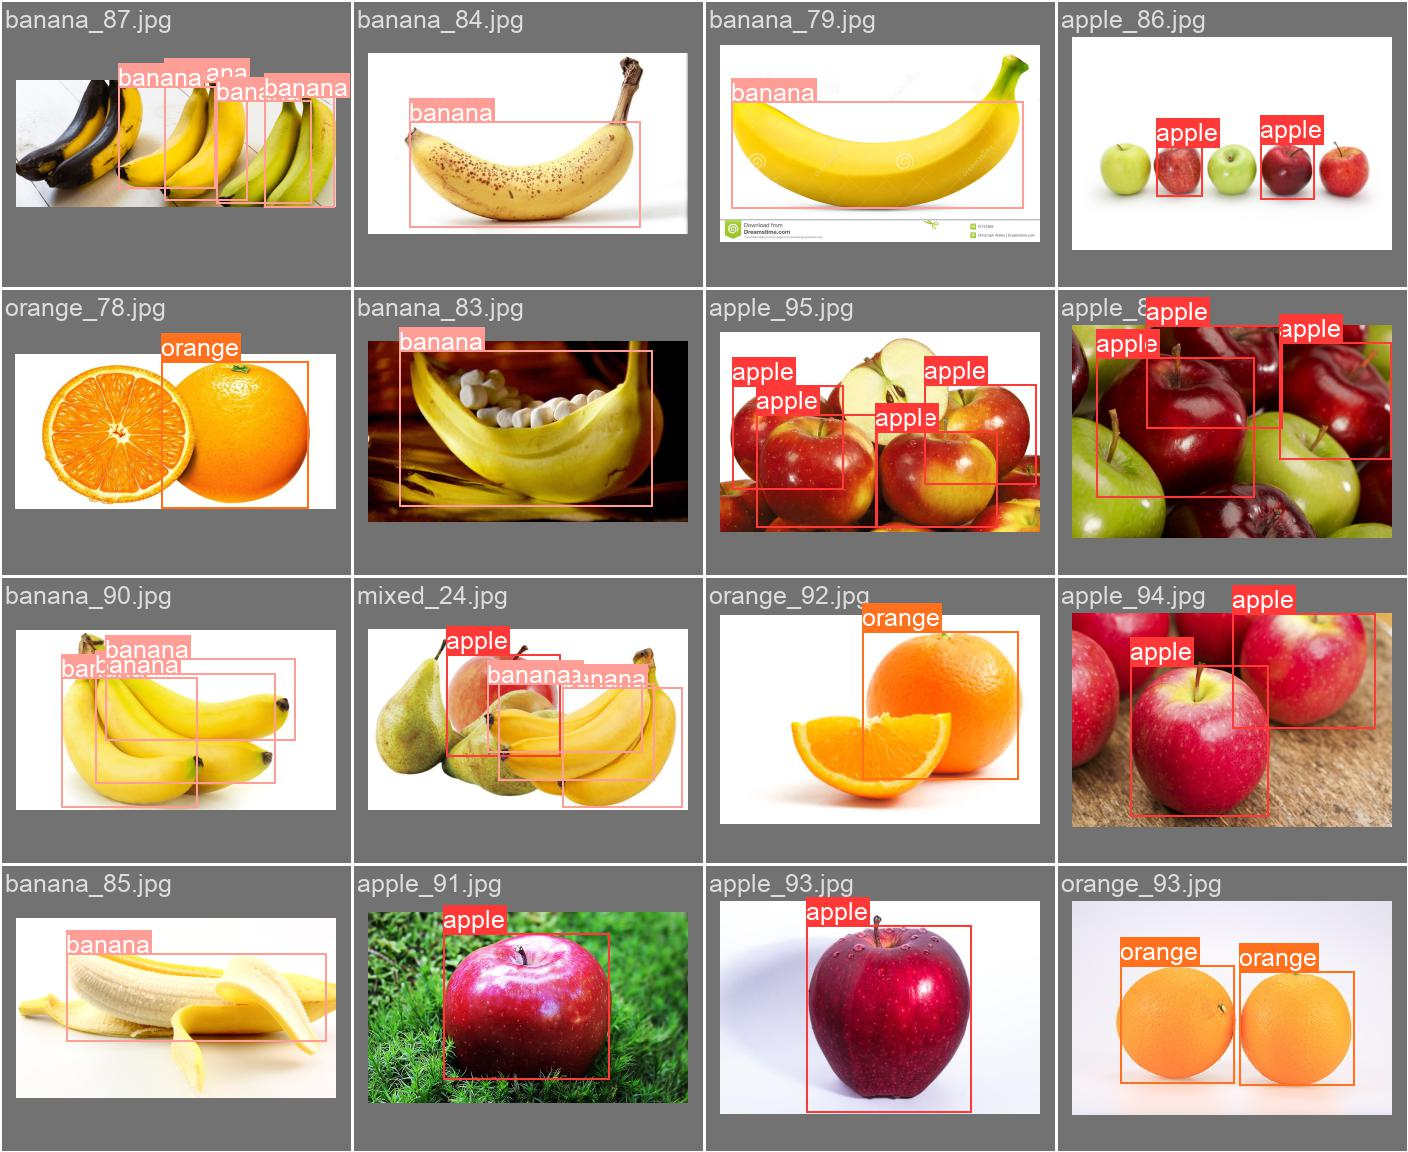

In [41]:

Image(filename='/content/yolov5/runs/train/exp2/val_batch0_labels.jpg', width=800)  # test batch 0 labels


**Sample images from val set with predictions**

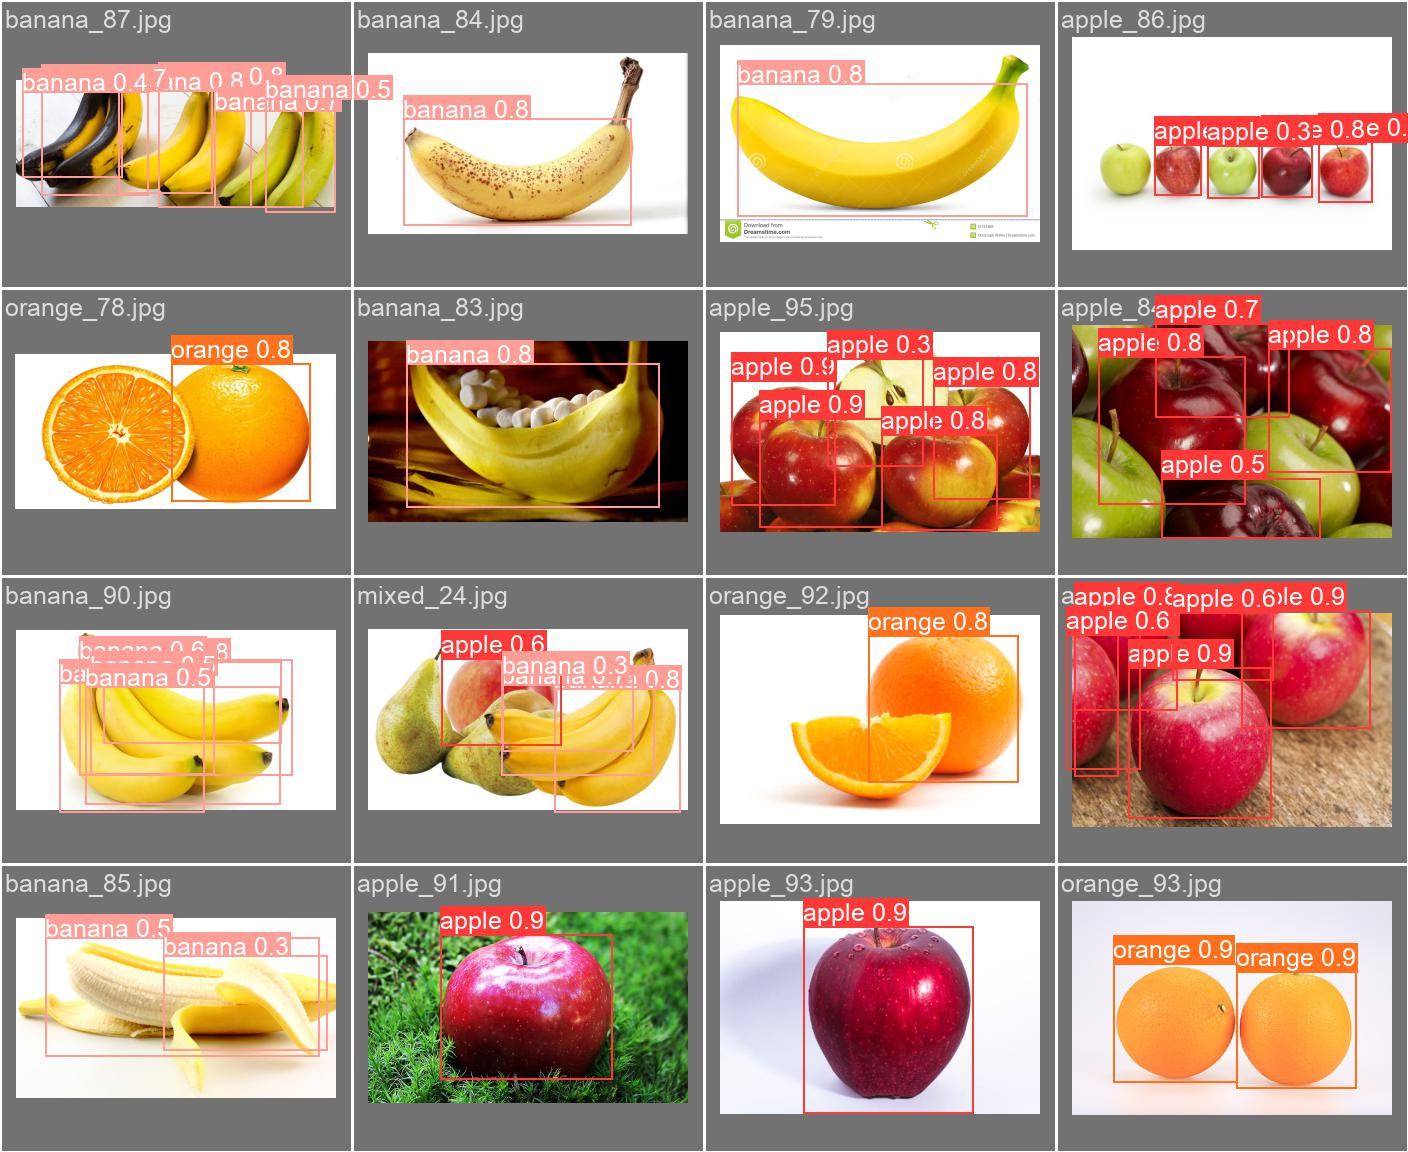

In [42]:
Image(filename='/content/yolov5/runs/train/exp2/val_batch0_pred.jpg', width=800) 

**7. Conclusion**

The model has acheived an overall score mAP_50 = 0.932 and mAP_50-95 = 0.64